In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from neighborhoods import admin_wards
from neighborhoods import district_neighborhoods

In [2]:
random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/additional_data.csv')
df.shape

(15975, 9)

In [4]:
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [5]:
df = df.drop_duplicates()
df = df.replace({True: 1, False: 0})
df['district'] = df['district'].replace('Arganzuela', 'arganzuela')

df = drop_outliers_iqr(df, 'price')


In [6]:
def has_weird_characters(input_string):
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    return bool(pattern.search(input_string))

def replace_str_values(df, column, input_tuple_list):
    for item in input_tuple_list:
        df[column] = df[column].str.replace(item[0], item[1])
    
    return df


In [7]:
input_tuple_list = [('Virgen del Cortijo', 'Valdefuentes'), ('Tablas', 'Valverde'), ('Tablas', 'Valverde'), ('Sanchinarro', 'Valdefuentes'), ('Arroyo del Fresno', 'Mirasierra'), ('Buena Vista', 'Buenavista'), ('Ambroz', 'Casco Histórico de Vicálvaro'), ('Águilas', 'Las Águilas'), ('-', ' '), ('Ã³', 'ó'), ('Ã¼', 'ü'),  ('Ã©', 'é'), ('Ã±', 'ñ'), ('Ã\xad', 'í'), ('Ã\x81', 'Á'), ('Ãº', 'ú'),  ('Ã¡', 'á')]

In [8]:
df = replace_str_values(df, 'neighborhood', input_tuple_list)


df['neighborhood'] = df['neighborhood'].replace('Chalet en Águilas', 'Las Águilas')
df['neighborhood'] = df['neighborhood'].replace('Águilas', 'Las Águilas')

for item in df['neighborhood'].values:
    for barrio in admin_wards:
        if barrio in item:
            df['neighborhood'] = df['neighborhood'].replace(item, barrio)

In [9]:
not_barrios = []


for item in df['neighborhood'].values:
    if item not in admin_wards:
        not_barrios.append(item)


set(not_barrios), len(set(df['neighborhood'].values))

({'Los Berrocales', 'Montecarmelo', 'Palomeras sureste', 'Pau de Carabanchel'},
 130)

In [10]:
df.shape

(12975, 9)

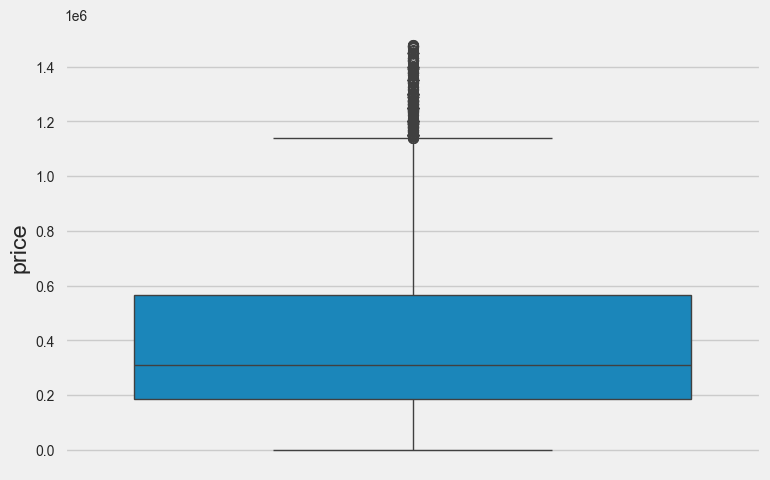

In [11]:
sns.boxplot(df['price'])
plt.show()

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12975 entries, 0 to 15974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         12975 non-null  int64  
 1   house_type    12975 non-null  object 
 2   house_type_2  12521 non-null  object 
 3   rooms         12975 non-null  int64  
 4   m2            12975 non-null  float64
 5   elevator      12975 non-null  int64  
 6   garage        12975 non-null  int64  
 7   neighborhood  12975 non-null  object 
 8   district      12975 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 1013.7+ KB


In [14]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [15]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

,price
price,1.000000
m2,0.773151
rooms,0.490906
elevator,0.363338
garage,0.274575


In [16]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'price']]
y = df['price']

In [17]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



# Initialize models
logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

ridge_classifier_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RidgeClassifier())
])

lasso_logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='saga'))
])

elastic_net_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

# Train and evaluate


In [18]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    target = 'price',
    ignore_features=[],
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    remove_multicollinearity=True,
    transformation= True,
    transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore'
)

,Description,Value
0,Session id,1974
1,Target,price
2,Target type,Regression
3,Original data shape,"(12975, 9)"
4,Transformed data shape,"(12975, 29)"
5,Transformed train set shape,"(9082, 29)"
6,Transformed test set shape,"(3893, 29)"
7,Numeric features,4
8,Categorical features,4
9,Rows with missing values,3.5%


In [19]:
# compare baseline models
best_model = compare_models(exclude=['lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,62895.5470,9360010605.9952,96620.8900,0.9042,0.2107,0.1892,0.2620
lightgbm,Light Gradient Boosting Machine,65029.6624,9998592331.3013,99842.2943,0.8978,0.2164,0.1938,0.5890
et,Extra Trees Regressor,63485.0366,10395122755.8982,101818.7273,0.8937,0.2204,0.1902,0.2120
xgboost,Extreme Gradient Boosting,64984.9829,10399413489.6451,101828.7492,0.8936,0.2155,0.1926,0.0550
rf,Random Forest Regressor,65361.4283,10641229672.8225,103000.4381,0.8912,0.2220,0.1959,0.2310
gbr,Gradient Boosting Regressor,71775.4698,11655034233.7125,107811.3565,0.8809,0.2366,0.2140,0.0930
knn,K Neighbors Regressor,77460.5082,14663978624.1385,120907.1326,0.8499,0.2508,0.2201,0.0500
dt,Decision Tree Regressor,83566.0008,18891883118.4049,137232.6165,0.8067,0.2988,0.2478,0.0360
ridge,Ridge Regression,104845.0483,20299338886.3201,142398.1525,0.7921,0.5703,0.3614,0.0330
llar,Lasso Least Angle Regression,104847.7179,20299370371.8565,142398.2525,0.7921,0.5691,0.3615,0.0350


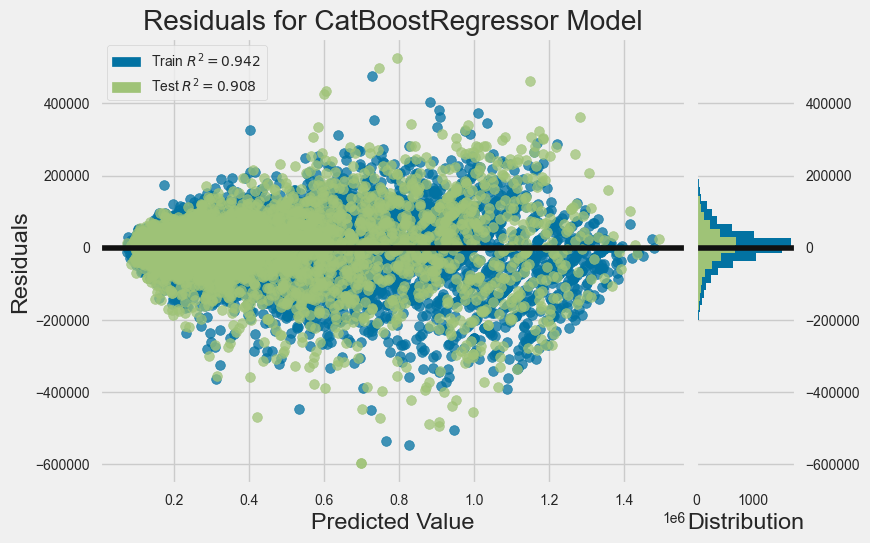

In [20]:
# plot residuals
plot_model(best_model, plot = 'residuals')

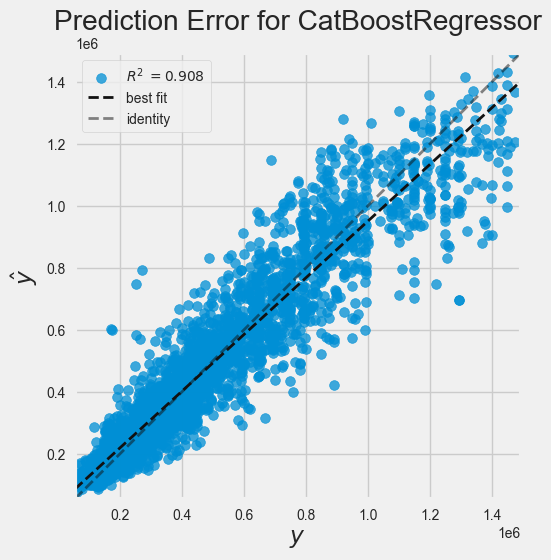

In [21]:
# plot error
plot_model(best_model, plot = 'error')

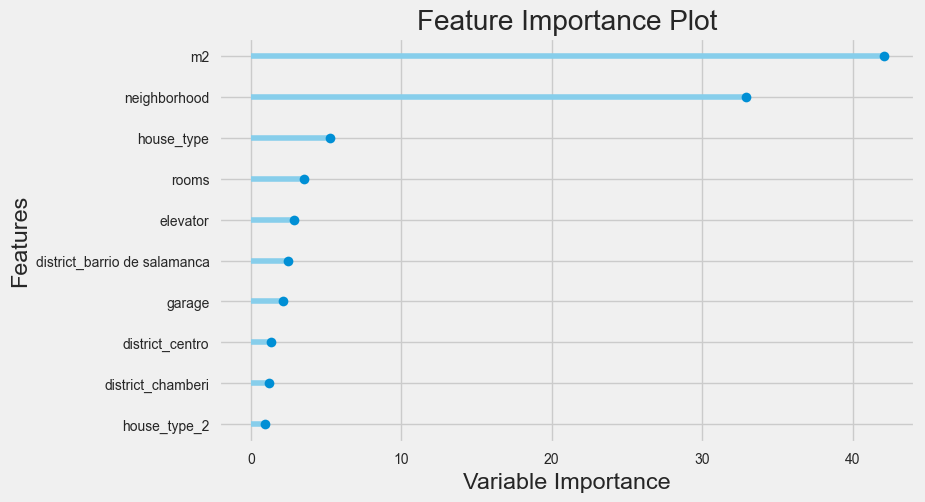

In [22]:
# plot feature importance
plot_model(best_model, plot = 'feature')

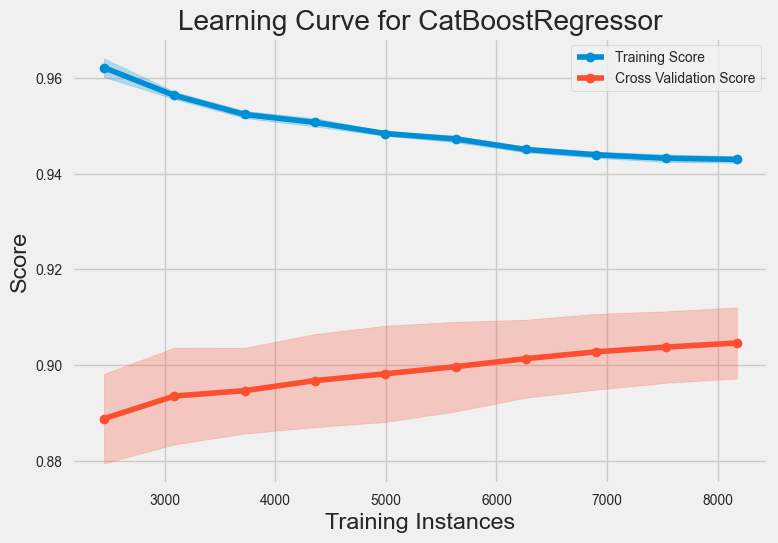

In [23]:
plot_model(best_model, plot = 'learning')

In [24]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Axes: >

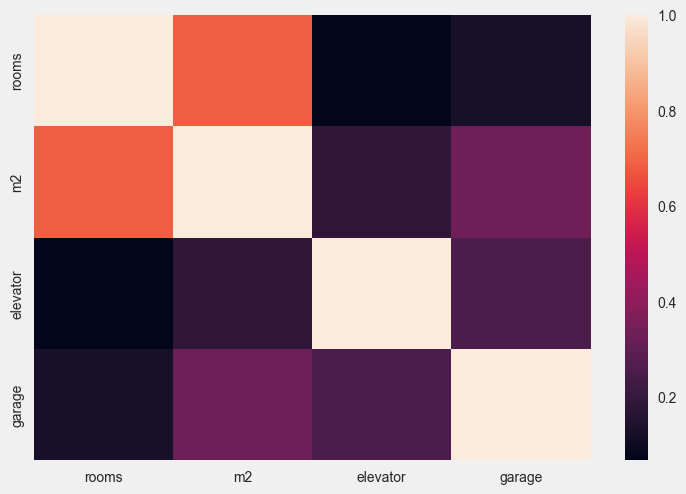

In [25]:
sns.heatmap(df[numerical_features].corr())

In [26]:
cb = create_model('catboost')
tuned_cb = tune_model(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63299.8400,8757743247.8388,93582.8149,0.9114,0.1932,0.1570
1,63777.6544,9660559863.4534,98288.1471,0.9002,0.1974,0.1577
2,62659.8646,10183513531.1408,100913.3962,0.8972,0.1989,0.1546
3,66258.3144,10851300766.9136,104169.5770,0.8948,0.2062,0.1590
4,64048.7332,9340541688.9080,96646.4779,0.9030,0.2090,0.1669
5,62387.2477,9376920674.4944,96834.5015,0.8984,0.2047,0.1628
6,67627.2117,10308500741.4645,101530.7872,0.9004,0.2117,0.1658
7,60679.6245,9303445261.1580,96454.3688,0.9040,0.2165,0.1685
8,60834.9736,8364608305.9015,91458.2326,0.9151,0.2688,0.4401


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,65343.4209,9372975192.8166,96814.1270,0.9052,0.2017,0.1633
1,65343.6353,10004442121.8206,100022.2081,0.8967,0.2038,0.1630
2,65751.2153,10967820040.3399,104727.3605,0.8893,0.2097,0.1661
3,68790.4379,11485631204.0547,107171.0372,0.8887,0.2151,0.1671
4,65890.7562,9851892521.5290,99256.7001,0.8976,0.2127,0.1718
5,64466.3498,9484903328.5976,97390.4684,0.8972,0.2130,0.1721
6,71234.6250,11241299838.5004,106024.9963,0.8914,0.2228,0.1763
7,65210.6656,9883425723.3680,99415.4199,0.8980,0.2263,0.1803
8,63841.9926,9110221632.5843,95447.4810,0.9076,0.2767,0.4523


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


K =  2 	WCSS Err. =  48173.14708189332
K =  3 	WCSS Err. =  37254.092772729
K =  4 	WCSS Err. =  29324.329402570846
K =  5 	WCSS Err. =  27754.16130280085
K =  6 	WCSS Err. =  25968.195013507768
K =  7 	WCSS Err. =  22905.205289232697
K =  8 	WCSS Err. =  21130.931535959025
K =  9 	WCSS Err. =  19618.11438786269
K =  10 	WCSS Err. =  18588.9245585163


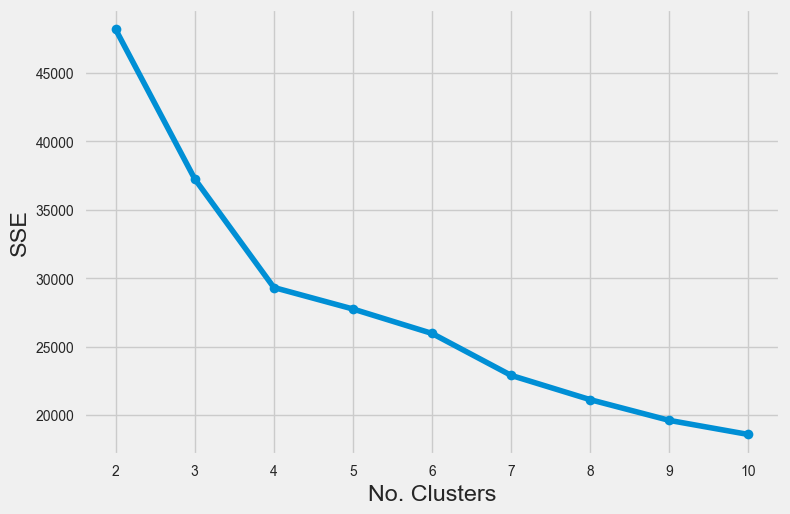

In [27]:
cluster_errors = []

for n_clusters in range(2, 11):
    kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ("pca", PCA(10, svd_solver='arpack')),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=42, verbose=0))
    ])
    kmeans_pipeline.fit(X)
    wcsse = kmeans_pipeline.named_steps["cluster"].inertia_
    print('K = ', n_clusters, '\tWCSS Err. = ', wcsse)
    cluster_errors.append(wcsse)

plt.plot(range(2, 11), cluster_errors, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("SSE")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3078
For n_clusters = 3 The average silhouette_score is : 0.4338
For n_clusters = 4 The average silhouette_score is : 0.4997
For n_clusters = 5 The average silhouette_score is : 0.4563
For n_clusters = 6 The average silhouette_score is : 0.3507
For n_clusters = 7 The average silhouette_score is : 0.2864
For n_clusters = 8 The average silhouette_score is : 0.4056
For n_clusters = 9 The average silhouette_score is : 0.4149
For n_clusters = 10 The average silhouette_score is : 0.2961


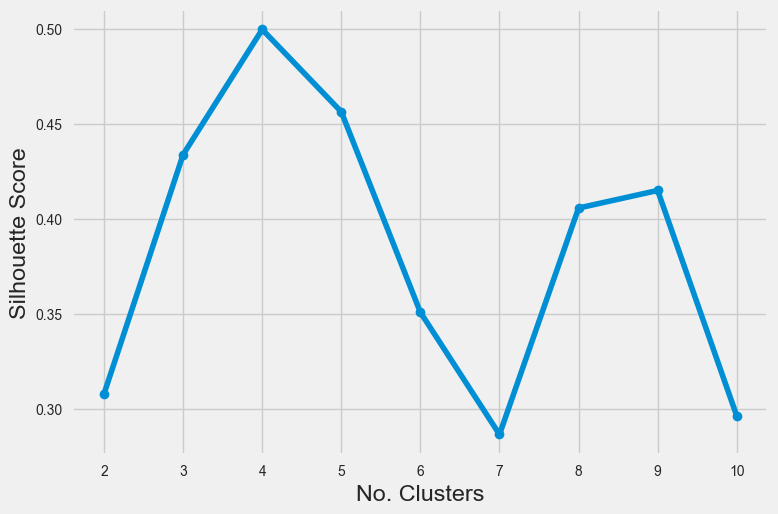

In [28]:
silhouette_s = []

for n_clusters in range(2, 11):
    kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ("pca", PCA(10, svd_solver='arpack')),
        ("cluster", KMeans(n_clusters=n_clusters))])
    df_X = kmeans_pipeline.fit_transform(X)
    cluster_labels = kmeans_pipeline.fit_predict(X)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_X, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(df_X, cluster_labels))

plt.plot(range(2, 11),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.show()


In [29]:
pipe_pca_kmean = Pipeline(
        [
          ('preprocessor', preprocessor),
          ('pca', PCA(10, svd_solver='arpack')),
          ("cluster", KMeans(n_clusters=3, verbose=0))
        ]
    )
pipe_pca_kmean.fit(X)
pipe_pca_kmean.predict(X)

array([1, 1, 2, ..., 2, 2, 0], dtype=int32)

In [30]:
kmean_cluster = pd.DataFrame(
    data = pipe_pca_kmean.named_steps["cluster"].labels_,
    index = X.index,
    columns=['kmean_cluster']
)

In [31]:
kmean_cluster

,kmean_cluster
0,1
1,1
2,2
3,1
4,2
...,...
15969,1
15971,2
15972,2
15973,2


In [32]:
kmean_cluster['kmean_cluster'].value_counts()

0    5996
2    3589
1    3390
Name: kmean_cluster, dtype: int64

In [33]:
X['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [34]:
df['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [35]:
df['price'] = df['price'].apply(lambda x: round(x, 2))
pd.options.display.float_format = '{:.2f}'.format

df_combined_describe_dict = {}
columns = []

df_0 = df[df['kmean_cluster']==0]
df_0_y_describe = df_0['price'].describe()
df_combined_describe_dict['df_0'] = df_0_y_describe
columns.append(('Price', 'Cluster 0'))

df_1 = df[df['kmean_cluster']==1]
df_1_y_describe = df_1['price'].describe()
df_combined_describe_dict['df_1'] = df_1_y_describe
columns.append(('Price', 'Cluster 1'))

df_2 = df[df['kmean_cluster']==2]
df_2_y_describe = df_2['price'].describe()
df_combined_describe_dict['df_2'] = df_2_y_describe
columns.append(('Price', 'Cluster 2'))


# df_3 = df[df['kmean_cluster']==3]
# df_3_y_describe = df_3['price'].describe()
# df_combined_describe_dict['df_3'] = df_3_y_describe
# columns.append(('Price', 'Cluster 3'))

df_combined_describe = pd.DataFrame(df_combined_describe_dict)

multi_index = pd.MultiIndex.from_tuples(columns)

df_combined_describe.columns = multi_index

df_combined_describe

Price                      
       Cluster 0  Cluster 1  Cluster 2
count    5996.00    3390.00    3589.00
mean   455621.09  587436.78  209657.83
std    300135.49  329743.77  150265.65
min       725.00   75000.00   47500.00
25%    229000.00  325000.00  133000.00
50%    360000.00  485000.00  164999.00
75%    610000.00  803750.00  225000.00
max   1480000.00 1480000.00 1395000.00

In [36]:
tsne = Pipeline(
        [
          ('preprocessor', preprocessor),
          ("tsne", TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init='random')),
        ]
    )

X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12975 samples in 0.001s...
[t-SNE] Computed neighbors for 12975 samples in 3.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12975
[t-SNE] Computed conditional probabilities for sample 2000 / 12975
[t-SNE] Computed conditional probabilities for sample 3000 / 12975
[t-SNE] Computed conditional probabilities for sample 4000 / 12975
[t-SNE] Computed conditional probabilities for sample 5000 / 12975
[t-SNE] Computed conditional probabilities for sample 6000 / 12975
[t-SNE] Computed conditional probabilities for sample 7000 / 12975
[t-SNE] Computed conditional probabilities for sample 8000 / 12975
[t-SNE] Computed conditional probabilities for sample 9000 / 12975
[t-SNE] Computed conditional probabilities for sample 10000 / 12975
[t-SNE] Computed conditional probabilities for sample 11000 / 12975
[t-SNE] Computed conditional probabilities for sample 12000 / 12975
[t-SNE] Computed conditional probabilities for sa

In [37]:
le = LabelEncoder()

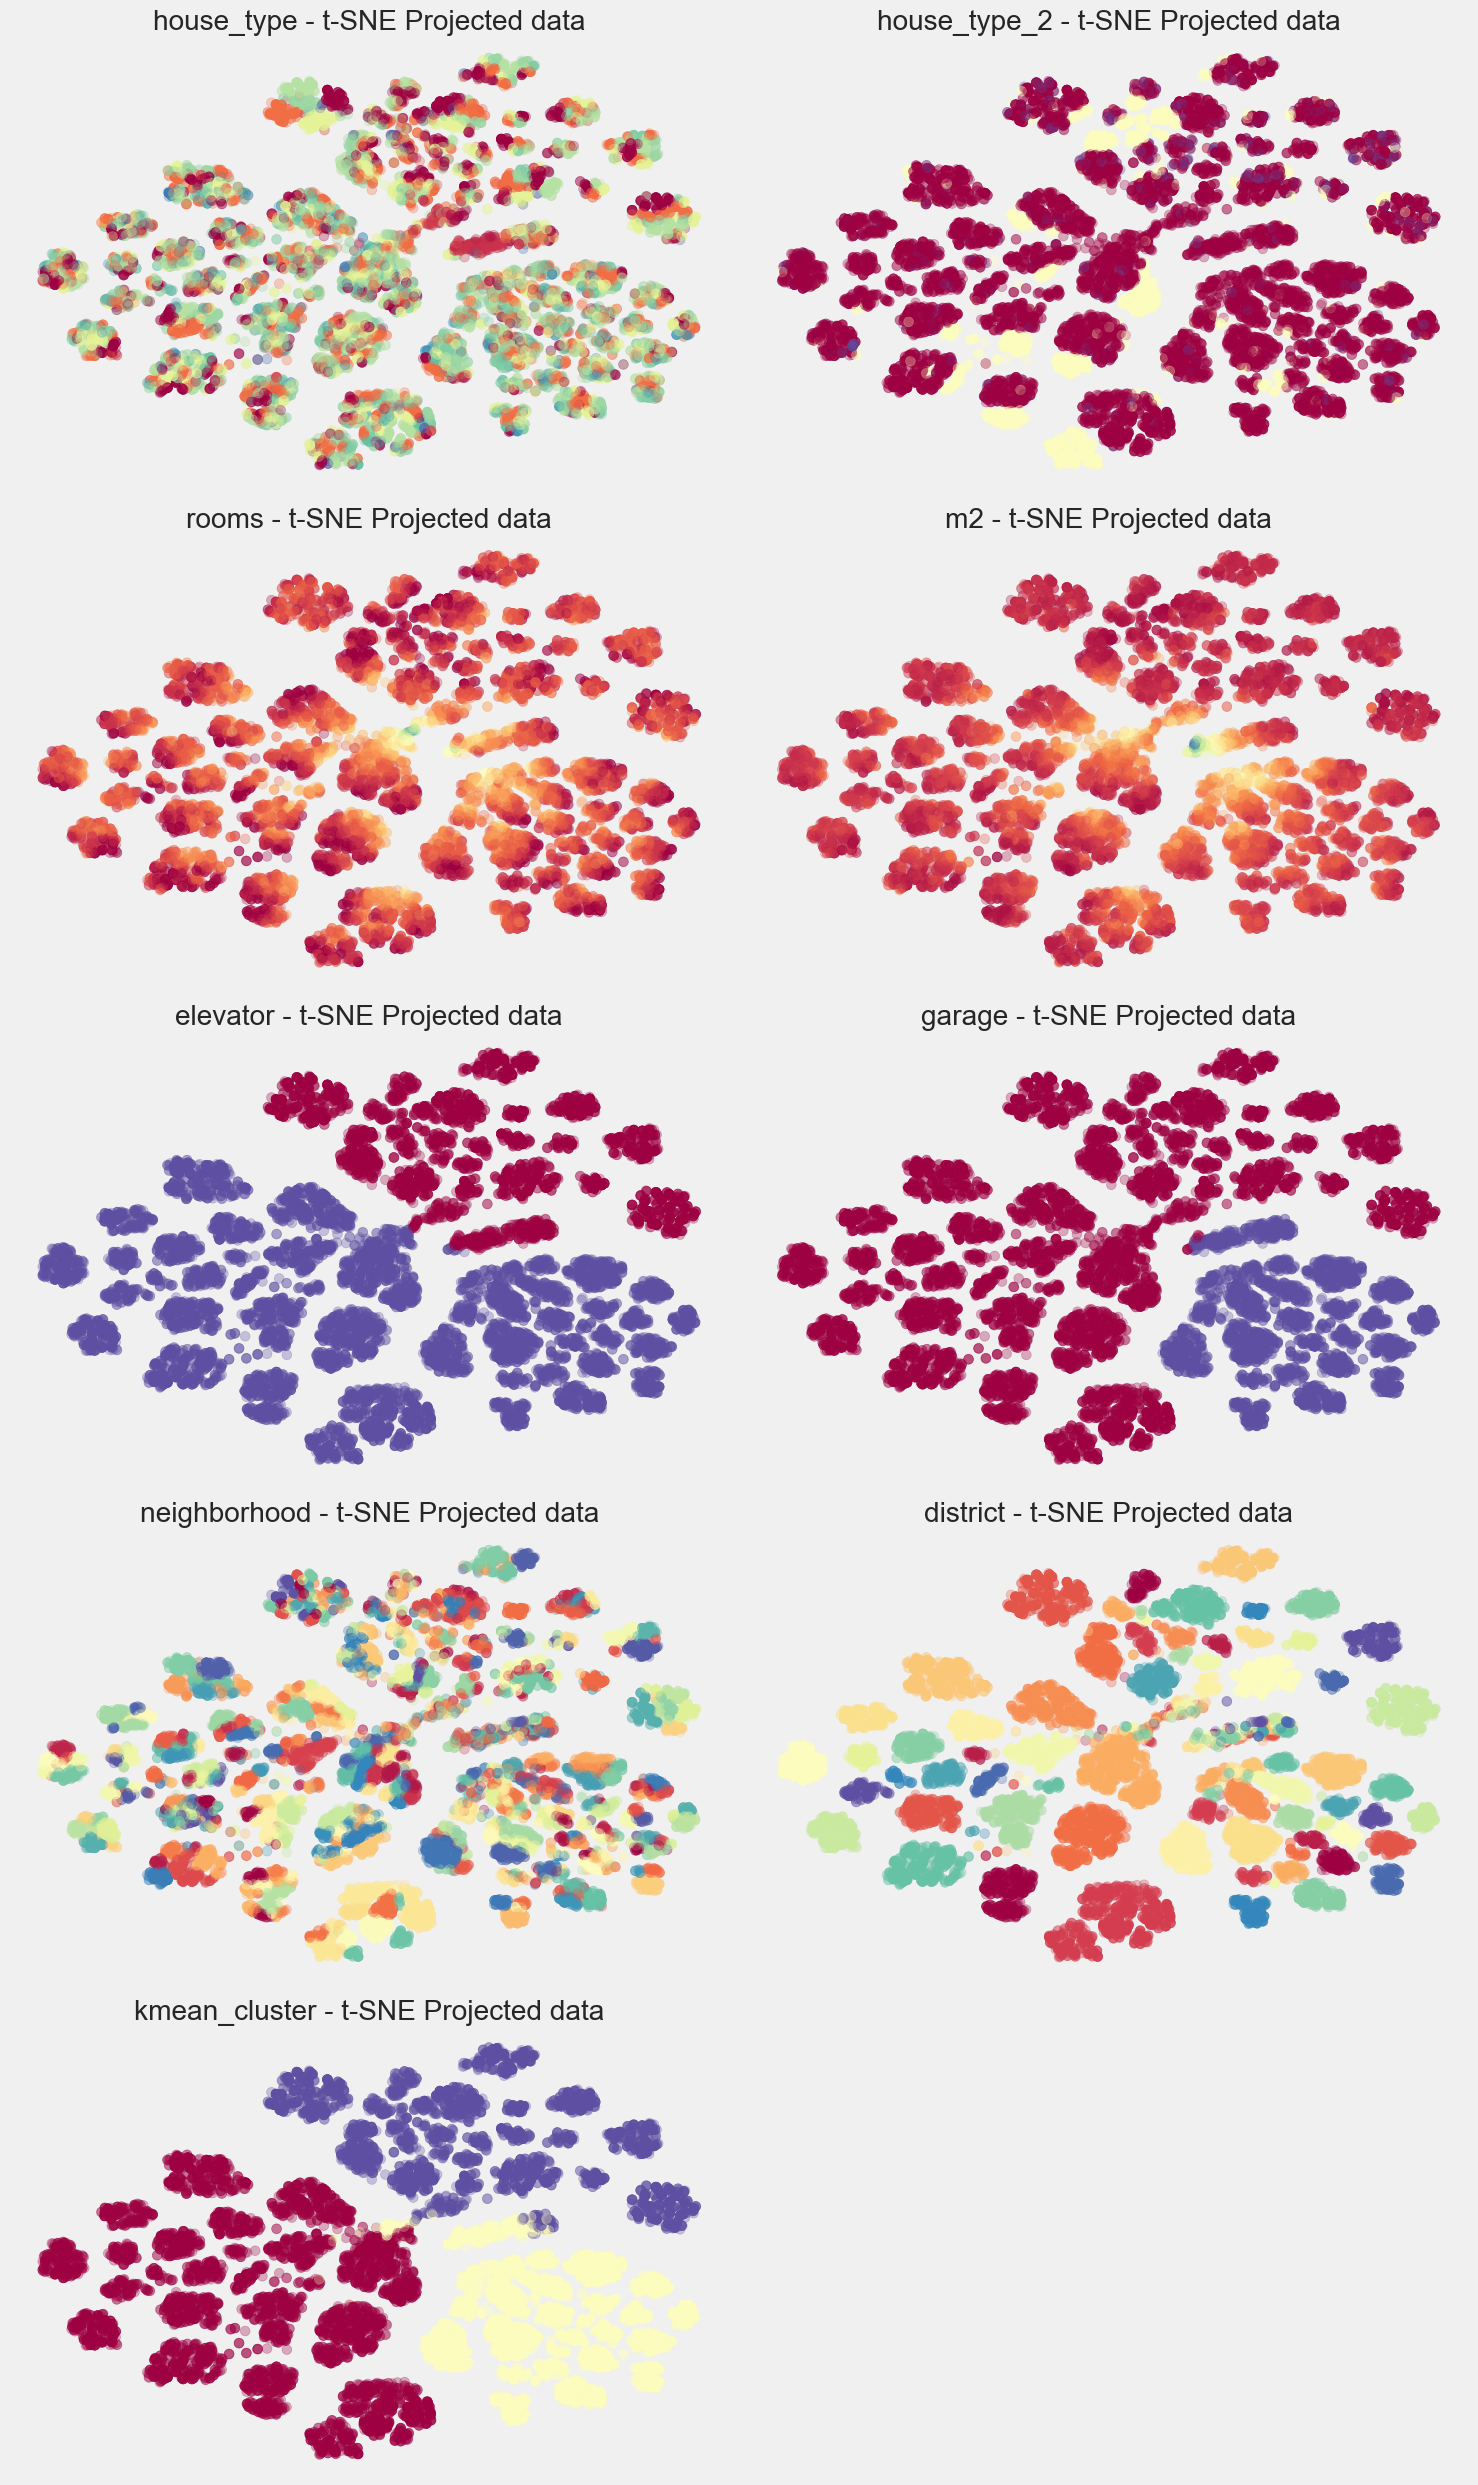

In [38]:
nrows = 8
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (15, 40))

axs = axs.flatten()

le = LabelEncoder()

for i, column in enumerate(X.columns):
    if i >= len(axs):
        break
    ax = axs[i]
    if column in categorical_features:
        encoded_column = le.fit_transform(df[column])
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=encoded_column, cmap=plt.cm.Spectral, alpha=0.3)
    else:
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[column], cmap=plt.cm.Spectral, alpha=0.3)

    ax.set_title(f'{column} - t-SNE Projected data')
    ax.axis('tight')
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [39]:
df_0.columns

Index(['price', 'house_type', 'house_type_2', 'rooms', 'm2', 'elevator',
       'garage', 'neighborhood', 'district', 'kmean_cluster'],
      dtype='object')

In [40]:
num_features_plot = ['price', 'm2']

In [51]:
def plot_clusters(column, df_list, numerical_features, rotate=False):
    print(rotate)
    if column in numerical_features:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        for i, df in enumerate(df_list):
            sns.kdeplot(data=df, x=column, ax=ax, label=f'Cluster {i}', shade=True)
        ax.set_title(f'KDE Plot - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.legend()
        if rotate:
            plt.xticks(rotation=360)
    else:
        cluster_colors = ['#69ACD9', '#E8917D', '#E2C480']
        combined_df = pd.concat([df.assign(cluster=i) for i, df in enumerate(df_list)])
        proportions = combined_df.groupby([column, 'cluster']).size().reset_index(name='count')
        proportions['proportion'] = proportions.groupby(column)['count'].apply(lambda x: x / float(x.sum()))
        pivot_df = proportions.pivot(index=column, columns='cluster', values='proportion').fillna(0)
        pivot_df = pivot_df.sort_values(by=0)
        fig, ax = plt.subplots(figsize=(10, 5))
        pivot_df.plot(kind='bar', stacked=True, ax=ax, color=cluster_colors[:pivot_df.shape[1]])
        ax.set_title(f'Relative Proportions - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Proportion')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        if rotate:
            plt.xticks(rotation=90)
        else:
            plt.xticks(rotation=0)
    plt.show()

False


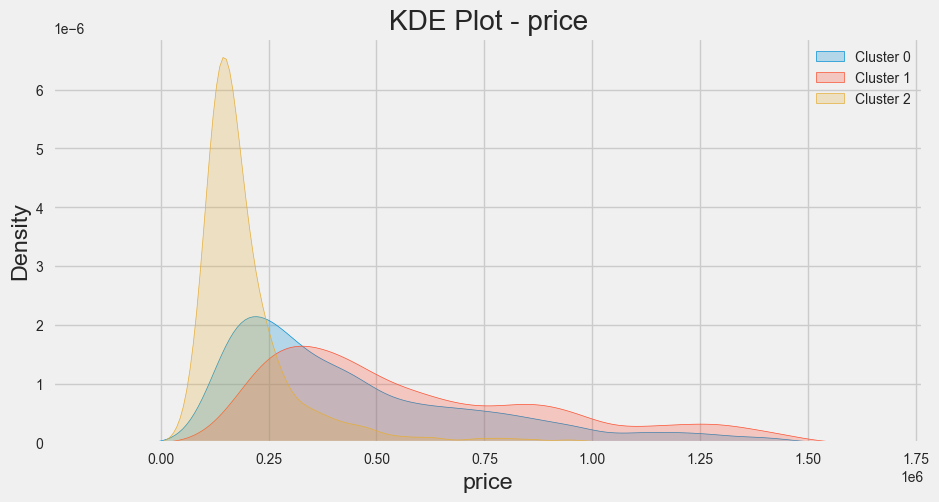

In [42]:
plot_clusters('price', [df_0, df_1, df_2], num_features_plot)

False


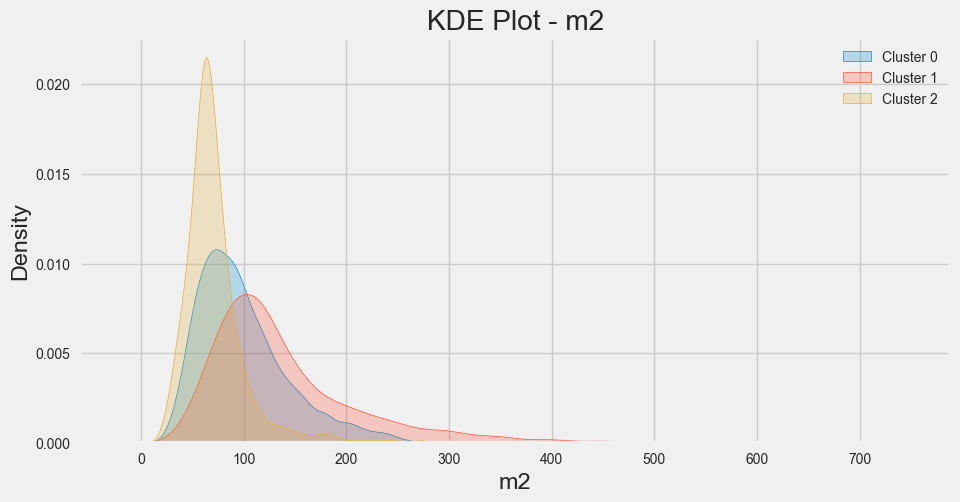

In [43]:
plot_clusters('m2', [df_0, df_1, df_2], num_features_plot)

True


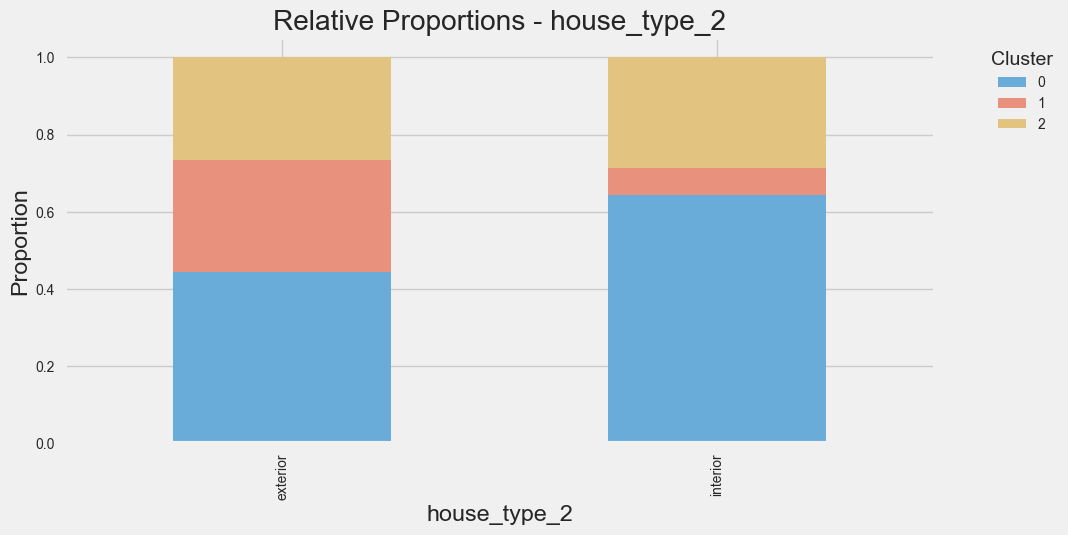

In [52]:
plot_clusters('house_type_2', [df_0, df_1, df_2], num_features_plot, True)

True


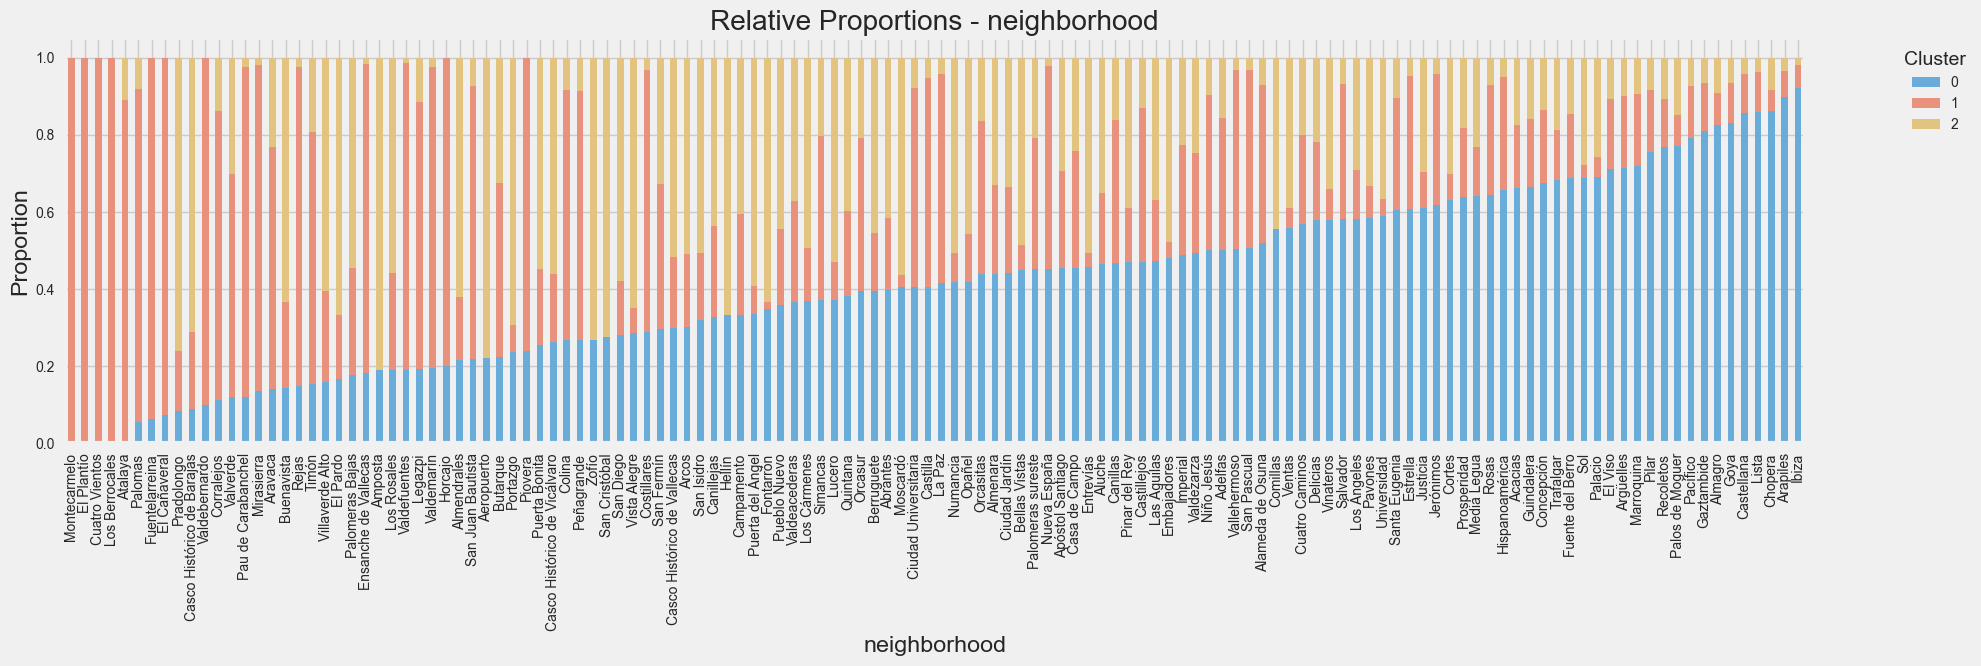

In [46]:
plot_clusters('neighborhood', [df_0, df_1, df_2], num_features_plot, True)